In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from itertools import chain
import seaborn as sns

In [17]:
f_name_arabic = '/home/aoq559/dev/transformer/lm-arithmetic/out/EleutherAI/pythia-12b-deduped-v0/n_operands3/template_typeall/max_n20/n_shots0/examples_n30/seed0/intervention_1_arabic_indirect_attention_layer_output_all_tokens_position_task_further_templates.feather'
data_arabic = pd.read_feather(f_name_arabic)
split_string = f_name_arabic.split("intervention_1_")
f_name_words = split_string[0] + "intervention_1_words" + split_string[1][6:]
data_words = pd.read_feather(f_name_words)
data_arabic = pd.read_feather(f_name_arabic)
split_string = f_name_arabic.split("intervention_1_")
f_name_words = split_string[0] + "intervention_1_words" + split_string[1][6:]
data_words = pd.read_feather(f_name_words)


In [18]:
data_arabic['IE'] = 0.5 * ((data_arabic['res_base_prob'] - data_arabic['res_base_alt_prob']) / data_arabic['res_base_alt_prob'] + 
                    (data_arabic['res_alt_alt_prob'] - data_arabic['res_alt_prob']) / data_arabic['res_alt_prob'])

data_arabic['IE_logits'] = 0.5 * ((data_arabic['res_base_logit'] - data_arabic['res_base_alt_logit']) / data_arabic['res_base_alt_logit'] +
                            (data_arabic['res_alt_alt_logit'] - data_arabic['res_alt_logit']) / data_arabic['res_alt_logit'])

data_arabic['patching_effect'] = (data_arabic['res_base_logit'] - data_arabic['res_alt_logit']) - (data_arabic['res_base_alt_logit'] - data_arabic['res_alt_alt_logit'])
data_arabic['patching_effect_normalized'] = ((data_arabic['res_base_logit'] - data_arabic['res_alt_logit']) - (data_arabic['res_base_alt_logit'] - data_arabic['res_alt_alt_logit'])) / (data_arabic['res_base_base_logit'] - data_arabic['res_alt_base_logit'])
data_arabic['patching_effect_prob'] = (data_arabic['res_base_prob'] - data_arabic['res_alt_prob']) - (data_arabic['res_base_alt_prob'] - data_arabic['res_alt_alt_prob'])
data_arabic['patching_effect_prob_normalized'] = ((data_arabic['res_base_prob'] - data_arabic['res_alt_prob']) - (data_arabic['res_base_alt_prob'] - data_arabic['res_alt_alt_prob'])) / (data_arabic['res_base_base_prob'] - data_arabic['res_alt_base_prob'])
data_arabic['representation'] = 'arabic'
data_words['IE'] = 0.5 * ((data_words['res_base_prob'] - data_words['res_base_alt_prob']) / data_words['res_base_alt_prob'] + 
                    (data_words['res_alt_alt_prob'] - data_words['res_alt_prob']) / data_words['res_alt_prob'])

data_words['IE_logits'] = 0.5 * ((data_words['res_base_logit'] - data_words['res_base_alt_logit']) / data_words['res_base_alt_logit'] +
                            (data_words['res_alt_alt_logit'] - data_words['res_alt_logit']) / data_words['res_alt_logit'])

data_words['patching_effect'] = (data_words['res_base_logit'] - data_words['res_alt_logit']) - (data_words['res_base_alt_logit'] - data_words['res_alt_alt_logit'])
data_words['patching_effect_normalized'] = ((data_words['res_base_logit'] - data_words['res_alt_logit']) - (data_words['res_base_alt_logit'] - data_words['res_alt_alt_logit'])) / (data_words['res_base_base_logit'] - data_words['res_alt_base_logit'])
data_words['patching_effect_prob'] = (data_words['res_base_prob'] - data_words['res_alt_prob']) - (data_words['res_base_alt_prob'] - data_words['res_alt_alt_prob'])
data_words['patching_effect_prob_normalized'] = ((data_words['res_base_prob'] - data_words['res_alt_prob']) - (data_words['res_base_alt_prob'] - data_words['res_alt_alt_prob'])) / (data_words['res_base_base_prob'] - data_words['res_alt_base_prob'])
data_words['representation'] = 'words'

In [19]:
data = pd.concat([data_arabic, data_words], ignore_index=True)
data

,example,template_id,n_vars,base_string,alt_string,few_shots,equation,res_base,res_alt,res_base_base_prob,...,res_alt_prob,res_base_logit,res_alt_logit,IE,IE_logits,patching_effect,patching_effect_normalized,patching_effect_prob,patching_effect_prob_normalized,representation
0,0,-,2,The result of 6 + 6 + 5 =,The result of 6 + 6 + 5 =,,({x}+{y} + {z}),17,17,0.545350,...,0.548838,16.734375,16.734375,0.000020,4.363116e-07,0.0,NaN,0.0,NaN,arabic
1,0,-,2,The result of 6 + 6 + 5 =,The result of 6 + 6 + 5 =,None,({x}+{y} + {z}),17,17,0.545350,...,0.548838,16.734375,16.734375,0.000020,4.363116e-07,0.0,NaN,0.0,NaN,arabic
2,0,-,2,The result of 6 + 6 + 5 =,The result of 6 + 6 + 5 =,None,({x}+{y} + {z}),17,17,0.545350,...,0.548838,16.734375,16.734375,0.000020,4.363116e-07,0.0,NaN,0.0,NaN,arabic
3,0,-,2,The result of 6 + 6 + 5 =,The result of 6 + 6 + 5 =,None,({x}+{y} + {z}),17,17,0.545350,...,0.548838,16.734375,16.734375,0.000020,4.363116e-07,0.0,NaN,0.0,NaN,arabic
4,0,-,2,The result of 6 + 6 + 5 =,The result of 6 + 6 + 5 =,None,({x}+{y} + {z}),17,17,0.545350,...,0.548838,16.734375,16.734375,0.000020,4.363116e-07,0.0,NaN,0.0,NaN,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37039,27,-,2,The result of four times two times two =,The result of four times two times two =,None,({x} * {y} * {z}),sixteen,sixteen,0.270784,...,0.260051,15.945312,15.945312,0.000818,0.000000e+00,0.0,NaN,0.0,NaN,words
37040,27,-,2,The result of four times two times two =,The result of four times two times two =,None,({x} * {y} * {z}),sixteen,sixteen,0.270784,...,0.262171,15.937500,15.937500,0.000523,1.200872e-07,0.0,NaN,0.0,NaN,words
37041,27,-,2,The result of four times two times two =,The result of four times two times two =,None,({x} * {y} * {z}),sixteen,sixteen,0.270784,...,0.261997,15.945312,15.945312,0.000544,0.000000e+00,0.0,NaN,0.0,NaN,words
37042,27,-,2,The result of four times two times two =,The result of four times two times two =,None,({x} * {y} * {z}),sixteen,sixteen,0.270784,...,0.262126,15.953125,15.953125,0.000528,1.199696e-07,0.0,NaN,0.0,NaN,words


In [20]:
np.mean(data.res_base != data.pred_alt)

0.239067055393586

In [21]:
data.base_string[0] == data.alt_string[0]

True

In [22]:
first_few_shots = data.groupby(['operation', 'representation'])['few_shots'].first()
first_few_shots = first_few_shots.reset_index()
first_few_shots['few_shot_string'] = first_few_shots['few_shots'].apply(lambda x: x.split())
def split_on_special_characters(lst):
    # Define the regular expression pattern
    pattern = r'(\w+)([!,:?])'
    # Initialize an empty list to store the results
    result = []
    for item in lst:
        # Find all matches in the string
        matches = re.findall(pattern, item)
        if matches:
            # If matches are found, extend the result list with the split elements
            for match in matches:
                result.extend(match)
        else:
            # If no matches, just append the item as it is
            result.append(item)
    return result
# Apply the function to the 'few_shot_string' column
first_few_shots['few_shot_string'] = first_few_shots['few_shot_string'].apply(split_on_special_characters)
unique_examples_by_operation = data.groupby('operation')['example'].nunique()
first_few_shots['n_instances'] = first_few_shots['operation'].map(unique_examples_by_operation)

data['position_first_operator'] = data['op1_pos'] + 1
data['position_second_operator'] = data['op3_pos'] - 1
data['position_last_token'] = data.groupby('example')['position'].transform('max')
data['positon_equality_token'] = data['position_last_token'] - 1


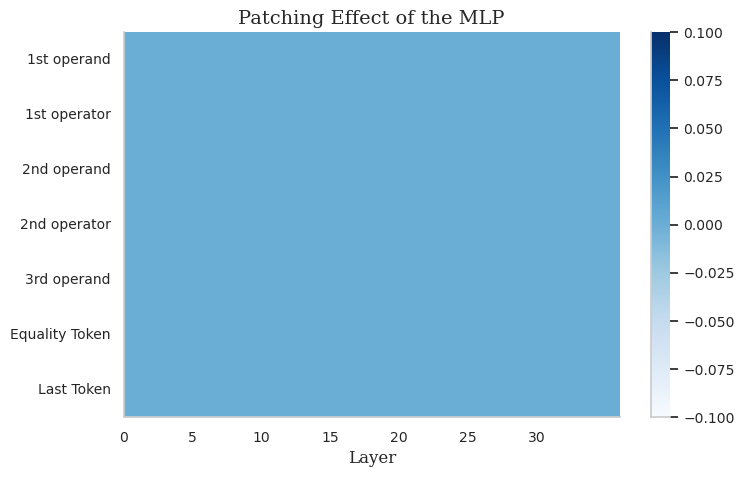

In [24]:
matrix = np.empty((7, len(data['layer'].unique())))
for i, op in enumerate(['op1_pos', 'position_first_operator', 'op2_pos', 'position_second_operator', 'op3_pos', 'positon_equality_token', 'position_last_token']):
    for j, layer in enumerate(data['layer'].unique()):
        subset_df = data[data[op] == data['position']]
        subset_df = subset_df[subset_df['layer'] == layer]
        matrix[i, j] = subset_df['patching_effect'].mean()

df = pd.DataFrame(matrix, index=['1st operand', '1st operator', '2nd operand', '2nd operator', '3rd operand', 'Equality Token', 'Last Token'], columns=data['layer'].unique())

plt.figure(figsize=(8, 5))
sns.set(font_scale=1.1)
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.heatmap(df, cmap="Blues", annot=False, fmt=".2f", cbar=True)

# set x-axis ticks to the range of unique layers
ax.set_xticks(range(data.layer.max()))

# set x-axis labels to the range of unique layers
ax.set_xticklabels(range(data.layer.max()), fontsize=10, rotation=0)
plt.xlabel('Layer', fontsize=12, fontname='DeJavu Serif')

for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 5 != 0:
        label.set_visible(False)

# Y-axis adjustments: Make labels horizontal and remove the y-axis title
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, rotation=0)
plt.ylabel('')  # Remove y-axis title

# Title and other adjustments
plt.title('Patching Effect of the MLP', fontsize=14, fontname='DeJavu Serif')

# Adjust color bar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

sns.despine()
plt.show()